 # **Imports**

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torchtext.vocab import GloVe, vocab, FastText
from nltk.tokenize import TweetTokenizer
from tqdm.notebook import tqdm
from torch.utils.data import Dataset
import torch.nn.functional as F
from termcolor import colored
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_curve
import torch.optim as optim
from torch.utils.data import DataLoader
!pip install pytorch-crf
from torchcrf import CRF
!pip install datasets
from datasets import load_dataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 2.4 MB/s eta 0:0

# **Loading Friends dataset**

In [ ]:
train_data = pd.read_csv("friends_train.csv.txt")
valid_data = pd.read_csv("friends_valid.csv.txt")
test_data = pd.read_csv("friends_test.csv.txt")

In [ ]:
train_data["Emotion"].value_counts()

neutral     4710
joy         1743
surprise    1205
anger       1109
sadness      683
disgust      271
fear         268
Name: Emotion, dtype: int64

# **Definition of processing functions**




## **Load Embedding**

In [ ]:
# pretrained_vectors = GloVe(name="6B", dim='50')
pretrained_vectors = FastText(language='en')

.vector_cache/wiki.en.vec: 6.60GB [02:55, 37.6MB/s]                            
100%|██████████| 2519370/2519370 [05:16<00:00, 7965.83it/s]


In [ ]:
pretrained_vectors.stoi
pretrained_vocab = vocab(pretrained_vectors.stoi)

In [ ]:
pretrained_vocab = vocab(pretrained_vectors.stoi)
unk_token = "<unk>"
unk_index = 0
pad_token = '<pad>'
pad_index = 1
pretrained_vocab.insert_token("<unk>",unk_index)
pretrained_vocab.insert_token("<pad>", pad_index)
#this is necessary otherwise it will throw runtime error if OOV token is queried 
pretrained_vocab.set_default_index(unk_index)
pretrained_embeddings = pretrained_vectors.vectors
pretrained_embeddings = torch.cat((torch.zeros(1,pretrained_embeddings.shape[1]),pretrained_embeddings))
pretrained_embeddings.size()

torch.Size([2519371, 300])

In [ ]:
vocab_stoi = pretrained_vocab.get_stoi()

In [ ]:
#we group all the sentences of a same conversation togeter in a dictionnary

def transform_data(data):
  dictionnaire = {}
  # Parcourir les lignes du dataframe et ajouter les textes à la clé "dialogue_id" correspondante
  for index, row in data.iterrows():
      if row['Dialogue_ID'] not in dictionnaire:
          # Si la clé n'existe pas dans le dictionnaire, l'initialiser comme une liste vide
          dictionnaire[row['Dialogue_ID']] = dict()
          dictionnaire[row['Dialogue_ID']]["text"] = []
          dictionnaire[row['Dialogue_ID']]["emotion"] = []
          #dictionnaire[row['Dialogue_ID']]["Sentiment"] = []
          # Ajouter le texte à la liste correspondante
      dictionnaire[row['Dialogue_ID']]["text"].append(row['Utterance'])
      dictionnaire[row['Dialogue_ID']]["emotion"].append(row['Emotion'])
      dictionnaire[row['Dialogue_ID']]["size"] = len(dictionnaire[row['Dialogue_ID']]["emotion"])
      #dictionnaire[row['Dialogue_ID']]["Sentiment"].append(row['Sentiment'])
  dictionnaire = {i: dictionnaire[k] for i, k in enumerate(dictionnaire)}
  return dictionnaire

In [ ]:
#we modify the tokenize function from the TD in order to make it suitable for our dictionnaries of conversations

tok = TweetTokenizer()

def tokenize_pad_numericalize_dialog(entry, vocab_stoi, max_length=20):
  ''' message level '''
  dialog = [[ vocab_stoi[token] if token in vocab_stoi else vocab_stoi['<unk>'] for token in tok.tokenize(e.lower()) ]
            for e in entry]
  padded_dialog = list()
  for d in dialog:
    if len(d) < max_length:    padded_dialog.append( d + [ vocab_stoi['<pad>'] for i in range(len(d), max_length) ] )
    elif len(d) > max_length:  padded_dialog.append(d[:max_length])
    else:                      padded_dialog.append(d)
  return padded_dialog

def tokenize_all_dialog(entries, vocab_stoi, max_dialog_length, max_message_length=20):
  ''' dialog level '''
  pad_message = [ vocab_stoi['<pad>'] ]
  pad_label = [0] # because 0 means dummy in dialog acts mapping
  res_dialog, res_emotion, res_sentiment = [], [], []

  text  = tokenize_pad_numericalize_dialog(entries["text"], vocab_stoi)
  if len(text) < max_dialog_length:    text = text + [ [vocab_stoi['<pad>']] * max_message_length for i in range(len(text), max_dialog_length)]   # pad_message * (max_dialog_length - len(text))
  elif len(text) > max_dialog_length:  text = text[:max_dialog_length] # keeps the last n messages
  res_dialog = text

  labels = entries["emotion"]
  #we fill artificially the emotions that don't exist as "neutral" ones
  if len(labels) < max_dialog_length:   labels = labels + [ 0 for i in range(len(labels), max_dialog_length) ]          # pad_label * (max_dialog_length - len(labels))
  #we remove the emotions belong the max_dialog_length
  elif len(labels) > max_dialog_length: labels = labels[:max_dialog_length]
  res_emotion = labels

  res = {'text': res_dialog, 'emotion': res_emotion}#, 'sentiment' : res_sentiment}
  return res




In [ ]:
def encode_value(value, encoding):
    encoded_value = encoding[value]
    return encoded_value

In [ ]:
# we loop over dictionary items and encode emotions string for the specified integer
def emotion_to_int(data, encoding):
  for key, value in data.items():
    for k, emotion in enumerate(data[key]["emotion"]):
      if emotion!=0:
        encoded_value = encode_value(emotion, encoding)
        data[key]["emotion"][k] = encoded_value
  return data

In [ ]:
#final creation of dataset, we call the previous functions and detail the specificities we would like
def prepare_friends_dataset(data, max_dialog_length, deal_with_imbalanced=False, remove_short_conv=(False,0), regroup_bad_emotions=False):
  if deal_with_imbalanced:
    # we group the 4 least frequent emotions together
    # and we also randomly delete some neutral emotions in the conversations as this label is too much present 
    others=["anger", "sadness", "disgust", "fear"]
    new_data = data.copy()
    new_data.loc[new_data["Emotion"].isin(others), "Emotion"] = "bad"
    # Count the number of rows with "Neutral" emotion
    num_neutral = len(new_data[new_data["Emotion"] == "neutral"])
    # Choose a random subset of rows to delete
    to_delete = new_data[new_data["Emotion"] == "neutral"].sample(n=int(num_neutral//2))
    # Drop the selected rows from the dataframe
    new_data = new_data.drop(to_delete.index)
    dico = transform_data(new_data)
  else:
    dico = transform_data(data)

  if remove_short_conv[0]:
    dico = {key: value for key, value in dico.items() if value["size"] >= remove_short_conv[1]}
    dico = {i: dico[key] for i, key in enumerate(sorted(dico.keys()))}
  
  dico = {k: tokenize_all_dialog(v, vocab_stoi, max_dialog_length) for k, v in dico.items()}
  
  if regroup_bad_emotions:
    encoding = {'neutral':0,
            'bad':1,
            'joy':2,
            'surprise':3}
    dico = emotion_to_int(dico, encoding)
  else:
    encoding = {'neutral':0,
            'joy':1,
            'surprise':2,
            'anger':3,
            'sadness':4,
            'disgust':5,
            'fear':6}
    dico = emotion_to_int(dico, encoding)
  return dico

In [ ]:
#function from the TP to allow the DataLoader from Pytorch to work correctly

class DialogActDataset(Dataset):
    def __init__(self, data, args):
      self.args = args
      self.data = data

    def __len__(self):
      return len(self.data)
    
    def __getitem__(self, idx):
      item = {
          "text": np.array(self.data[idx]['text']),
          "emotion": np.array(self.data[idx]['emotion']),
      }
      return item

# **Loading Daily Dialog dataset**

In [2]:
dailydialog = load_dataset('daily_dialog')

Generating train split:   0%|          | 0/11118 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset daily_dialog downloaded and prepared to /root/.cache/huggingface/datasets/daily_dialog/default/1.0.0/1d0a58c7f2a4dab5ed9d01dbde8e55e0058e589ab81fce5c2df929ea810eabcd. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

### **Emotion breakdown**

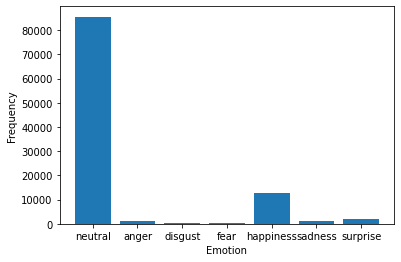

In [3]:
import matplotlib.pyplot as plt
import itertools
import collections

# Define the emotion labels
emotion_labels = {
    0: "neutral",
    1: "anger",
    2: "disgust",
    3: "fear",
    4: "happiness",
    5: "sadness",
    6: "surprise",
}

# Flatten the list of emotions from all dialogues
emotions = list(itertools.chain.from_iterable(dailydialog["train"]["emotion"] + dailydialog["validation"]["emotion"] + dailydialog["test"]["emotion"]))

# Compute the frequency of each emotion
emotion_counts = collections.Counter(emotions)

# Plot the distribution of emotions
plt.bar(emotion_counts.keys(), emotion_counts.values())
plt.xlabel("Emotion")
plt.ylabel("Frequency")
plt.xticks(list(emotion_counts.keys()), [emotion_labels[e] for e in emotion_counts.keys()])
plt.show()

In [ ]:
tok = TweetTokenizer()

def tokenize_pad_numericalize_dialog_DD(entry, vocab_stoi, max_length=20):
  ''' message level '''
  dialog = [ [ vocab_stoi[token] if token in vocab_stoi else vocab_stoi['<unk>'] for token in tok.tokenize(e.lower()) ] 
          for e in entry ]
  padded_dialog = list()
  for d in dialog:
    if len(d) < max_length:    padded_dialog.append( d + [ vocab_stoi['<pad>'] for i in range(len(d), max_length) ] )
    elif len(d) > max_length:  padded_dialog.append(d[:max_length])
    else:                      padded_dialog.append(d) 
  return padded_dialog

def tokenize_all_dialog_DD(entries, vocab_stoi, act_or_emotion, max_message_length=20, max_dialog_length=12):
  ''' dialog level '''
  pad_message = [ vocab_stoi['<pad>'] ]
  pad_label = [0] # because 0 means dummy in dialog acts mapping
  res_dialog, res_labels = [], []

  for entry in entries['dialog']:
    text  = tokenize_pad_numericalize_dialog_DD(entry, vocab_stoi)
    if len(text) < max_dialog_length:    text = text + [ [vocab_stoi['<pad>']] * max_message_length for i in range(len(text), max_dialog_length)]   # pad_message * (max_dialog_length - len(text))
    elif len(text) > max_dialog_length:  text = text[-max_dialog_length:] # keeps the last n messages
    res_dialog.append(text)

  for labels in entries[act_or_emotion]:
    if len(labels) < max_dialog_length:   labels = labels + [ 0 for i in range(len(labels), max_dialog_length) ]          # pad_label * (max_dialog_length - len(labels))
    elif len(labels) > max_dialog_length: labels = labels[-max_dialog_length:]
    res_labels.append(labels)

  res = {'text': res_dialog, 'emotion': res_labels}
  return res

# **Contextual Emotion classification model**

## **Our customed model : Hierarchical encoding with context aware attention network**

In [ ]:
class ContextAwareAttention(nn.Module):
    def __init__(self, hidden_dim):
        super(ContextAwareAttention, self).__init__()
        #this is this hidden dimension of the words encoding that will be input of the attention layer
        self.hidden_dim = hidden_dim
        #first layer of the attention mechanism : linear transformation of the encoded word
        self.attn1 = nn.Linear(hidden_dim, hidden_dim)
        #first layer of the attention mechanism : linear transformation of the previous sentence representation
        self.attn2 = nn.Linear(hidden_dim, hidden_dim)
        #second layer of the attention mechanism : computes the attention scores for each word in the input sentence        
        self.attn3 = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, encoder_outputs, prev_sentence_hidden_state):
        #energy corresponds to the output e^{\tau, t} of our article, tanh activation of the linear layer
        energy = torch.tanh(self.attn1(encoder_outputs) + self.attn2(prev_sentence_hidden_state))
        #computation of the attention weights of the words thanks to linear layer and softmax activation
        attention_weights = torch.softmax(self.attn3(energy), dim=1)
        #now, context vector is simply the ponderate sum of the encoded words * their attention weights
        context_vector = attention_weights * encoder_outputs
        context_vector = torch.sum(context_vector, dim=1)
        #we return the final single vector representation of the sentence       
        return context_vector, attention_weights

class ContextAwareHierarchicalAttentionRNN(nn.Module):
    def __init__(self, pretrained_embeddings, max_num_sentences, num_words_embedding, embedding_dim, args, sentence_hidden_dim, conversation_hidden_dim, num_layers, num_classes, dropout, with_CRF = False):
        super(ContextAwareHierarchicalAttentionRNN, self).__init__()
        self.sentence_hidden_dim = sentence_hidden_dim
        self.num_classes = num_classes
        self.max_num_sentences = max_num_sentences
        self.args = args
        #first layer of the network : transform the words into embeddings thanks to the pre-trained Embeddings FastText
        self.word_embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True)
        #2nd layer: bi-directionnal GRU for sentences in order to encode the words within a sentence and catch the links between words
        self.words_rnn = nn.GRU(input_size=embedding_dim, hidden_size=sentence_hidden_dim, num_layers=num_layers, dropout=dropout, bidirectional=True)
        #then, we apply our Attention class in order to perform a context aware self attention layer
        self.word_attention = ContextAwareAttention(hidden_dim=sentence_hidden_dim*2)
        #bi-directional GRU for conversations in order to encode the sentence representation within a conversation
        self.sentences_rnn = nn.GRU(input_size=sentence_hidden_dim*2, hidden_size=conversation_hidden_dim, num_layers=num_layers, dropout=dropout, bidirectional=True)
        #final fully-connected layer in order to be able after to predict probabilities for each utterance
        self.fc = nn.Linear(conversation_hidden_dim*2, num_classes)
        #if with_CRF=True, we add a CRF decoding layer that assign the label dependently with each other
        self.crf = CRF(num_classes)
        self.with_CRF = with_CRF

    #to comply with Pytorch implementation, we define the forward pass of our network
    def forward(self, conversations, seq_len=12):
        #we initialize an empty list to store the sentence representations from the output of the attention layer
        sentence_representations = []
        #max_num_sentences = max([len(conv) for conv in conversations["text"]])
        for conversation in conversations["text"]:
            #we successively call our layers between word embeddings and attention mechanism
            sentence_embeddings = self.word_embedding(conversation)
            sentence_hidden_states, _ = self.words_rnn(sentence_embeddings)
            #we store the previous sentence hidden state to be an input of the next attention layer : initialize at 0 for the first one
            prev_sentence_hidden_state = torch.zeros(1, sentence_hidden_states.size(1), self.sentence_hidden_dim*2).to(self.args["device"])
            for i in range(sentence_hidden_states.size(0)):
                current_sentence_hidden_state = sentence_hidden_states[i].unsqueeze(0)
                sentence_representation, _ = self.word_attention(current_sentence_hidden_state, prev_sentence_hidden_state)
                #add the new sentence vector to the sentence_representations list
                sentence_representations.append(sentence_representation.unsqueeze(0))
                prev_sentence_hidden_state = current_sentence_hidden_state
        #deal with Pytorch structure
        sentence_representations = torch.cat(sentence_representations, dim=0)
        sentence_representations = sentence_representations.view(-1, self.max_num_sentences, 2 * self.sentence_hidden_dim)
        #we get the hidden states of the sentences from a conversation
        conversation_hidden_states, _ = self.sentences_rnn(sentence_representations)
        #we pass it through the fully connected layer in order to have final outputs
        outputs = self.fc(conversation_hidden_states)
        outputs = outputs.view(-1, self.max_num_sentences, self.num_classes)

        #keep some dimension infos as variable for convenience
        batch_size, num_sentences, _ = outputs.size()
        
        #print(outputs.shape)
       # keep some dimension infos as variable for convenience
        batch_size = outputs.size(0)
        seq_len = outputs.size(1)
        #we use the CRF loss in this case that will help decoding the labels dependently
        if self.with_CRF:
          labels = conversations['emotion'].view(batch_size, seq_len)
          loss = -self.crf(outputs, labels)
          tag_seq = torch.tensor(self.crf.decode(outputs), device=self.args["device"])
          scores = outputs
          return loss, scores, tag_seq

        else:
          #from now on, it is the same syntax as the model from the TP, linked with the TP training loops
          # modify the outputs representation to prepare score computation
          outputs = outputs.view(batch_size*seq_len, -1)
          # apply a softmax on the outputs to obtain probabilities
          scores = F.log_softmax(outputs, 1)

          # get the predicted tags using the maximum probability from the softmax
          _, tag_seq  = torch.max(scores, 1)
          # reshape the predicted tags to follow the batch and sequence length
          tag_seq = tag_seq.view(batch_size, seq_len)
        
          if 'class_weights' in self.args:
          # class weights from args if there is any. It should be a torch tensor, but we move it to the dedicated device
          # we use class weights to influence the Negative Log Likelihood. Influencing in the same time the backpropagation and, thus, the update of the model
            loss_fn = nn.NLLLoss(weight=self.args['class_weights'].to(self.args["device"]))  
          else: 
            # if not 'class_weights' key in the args dict(), we use the Negative Log Likelihood as is
            loss_fn = nn.NLLLoss()

          # apply the loss function (Softmax + NLLLoss = Cross Entropy)
          loss = loss_fn(scores, conversations['emotion'].view(batch_size*seq_len))
          #loss = loss_fn(scores, conversations['label'].view(batch_size*seq_len))

          # we return 3 elements as a tuple : the loss, the softmax outputs, and the predicted tag set already in a good format
          return loss, scores, tag_seq


# **Train and validation loops from the TP**

In [ ]:
def train(model, optimizer, ep, args):
  # set the model into a training mode : the model's weights and parameters WILL BE updated!
  model.train()
  # initialize empty lists for losses and accuracies
  loss_it, acc_it = list(), list()

  # start the loop over all the training batches. This means one full epoch.
  for it, batch in tqdm(enumerate(train_loader), desc="Epoch %s:" % (ep), total=train_loader.__len__()):
    
    # put parameters of the model and the optimizer to zero before doing another iteration
    optimizer.zero_grad()
    model.zero_grad()

    # apply the model on the batch
    loss, logits, tag_seq = model(batch)
    # compute gradient values
    loss.backward()
    # indicate to the optimizer we've done a step
    optimizer.step()
    # append the value of the loss for the current iteration (it). .item() retrieve the nuclear value as a int/long
    loss_it.append(loss.item())
    
    # Those 3 lines compute the accuracy and then append it the same way as the loss above
    correct = (tag_seq.flatten() == batch['emotion'].flatten()).float().sum()
    acc = correct / batch['emotion'].flatten().size(0)
    acc_it.append(acc.item())

  # simple averages of losses and accuracies for this epoch
  loss_it_avg = sum(loss_it)/len(loss_it)
  acc_it_avg = sum(acc_it)/len(acc_it)
  
  # print useful information about the training progress and scores on this training set's full pass (i.e. 1 epoch)
  print("Epoch %s/%s : %s : (%s %s) (%s %s)" % (colored(str(ep), 'blue'),args['max_eps'] , colored('Training', 'blue'), colored('loss', 'cyan'), sum(loss_it)/len(loss_it), colored('acc', 'cyan'), sum(acc_it) / len(acc_it)))


In [ ]:
def inference(target, loader, model):
  """
    Args:
      target (str): modify the display, usually either 'validation' or 'test'
  """
  # set the model into a evaluation mode : the model's weights and parameters will NOT be updated!
  model.eval()

  # intialize empty list to populate later on
  loss_it, acc_it, f1_it = list(), list(), list()
  # preds = predicted values ; trues = true values .... obviously~
  preds, trues = list(), list()

  # loop over the loader batches
  for it, batch in tqdm(enumerate(loader), desc="%s:" % (target), total=loader.__len__()):
    # set an environnement without any gradient. So the tensor gradients are not considered 
    # (saves a lot of computation and memory, this is one of the many things that makes predicting far less costly than training)
    with torch.no_grad():
      # apply the model
      loss, logits, tag_seq = model(batch)
      # no need to backward() and other training stuff. Directly store the loss in the list
      loss_it.append(loss.item())
      
      # compute the accuracy and store it
      correct = (tag_seq.flatten() == batch['emotion'].flatten()).float().sum()
      acc = correct / batch['emotion'].flatten().size(0)
      acc_it.append(acc.item())
      
      # extend the predictions and true labels lists so we can compare them later on
      # note how we first ensure the tensor are on cpu (.cpu()), then we detach() the gradient from the tensor, before transforming it to a simple python list (.tolist())
      preds.extend(tag_seq.cpu().detach().tolist())
      trues.extend(batch['emotion'].cpu().detach().tolist())

  # compute the average loss and accuracy accross the iterations (batches)
  loss_it_avg = sum(loss_it)/len(loss_it)
  acc_it_avg = sum(acc_it)/len(acc_it)
  
  # print useful information. Important during training as we want to know the performance over the validation set after each epoch
  print("%s : (%s %s) (%s %s)" % ( colored(target, 'blue'), colored('loss', 'cyan'), sum(loss_it)/len(loss_it), colored('acc', 'cyan'), sum(acc_it) / len(acc_it)))

  # return the true and predicted values with the losses and accuracies
  return trues, preds, loss_it_avg, acc_it_avg, loss_it, acc_it

In [ ]:
def run_epochs(model, args):

  if args['cuda'] != -1:
      model.cuda(args['cuda'])
      device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      args['device'] = device
      print("device set to %s" % (device) )

  # we set the optimizer as Adam with the learning rate (lr) set in the arguments
  # you can look at the different optimizer available here: https://pytorch.org/docs/stable/optim.html
  optimizer = optim.Adam(model.parameters(), lr = args['lr'])

  # define an empty list to store validation losses for each epoch
  val_ep_losses = list()
  # iterate over the number of max epochs set in the arguments
  for ep in range(args['max_eps']):
    # train the model using our defined function
    train(model, optimizer, ep, args)
    # apply the model for inference using our defined function
    trues, preds, val_loss_it_avg, val_acc_it_avg, val_loss_it, val_acc_it = inference("validation", val_loader, model)
    # append the validation losses (good losses should normally go down)
    val_ep_losses.append(val_loss_it_avg)

  # return the list of epoch validation losses in order to use it later to create a plot
  return val_ep_losses
    

# **Train on Friends dataset**

#### **Result on total dataset, without weights, num_max_sentences = 12**

In [ ]:
args = {'bsize': 64}
train_dico = prepare_friends_dataset(train_data, max_dialog_length=12, deal_with_imbalanced=False, remove_short_conv=(False,0), regroup_bad_emotions=False)
valid_dico = prepare_friends_dataset(valid_data, max_dialog_length=12, deal_with_imbalanced=False, remove_short_conv=(False,0), regroup_bad_emotions=False)
test_dico = prepare_friends_dataset(test_data, max_dialog_length=12, deal_with_imbalanced=False, remove_short_conv=(False,0), regroup_bad_emotions=False)
train_loader = DataLoader(DialogActDataset(train_dico, args), batch_size=args['bsize'], num_workers=0, shuffle=True, drop_last=True)
val_loader   = DataLoader(DialogActDataset(valid_dico, args), batch_size=args['bsize'], num_workers=0, shuffle=True, drop_last=True)
test_loader  = DataLoader(DialogActDataset(test_dico, args), batch_size=args['bsize'], num_workers=0, shuffle=True, drop_last=True)

In [ ]:
# let's use our model for inference on the test set. We can short it by naming it "test our model"
# we set the target as "test" to print the correct info, and use the test loader
trues, preds, loss_it_avg, acc_it_avg, loss_it, acc_it = inference("test", test_loader, model)

test::   0%|          | 0/16 [00:00<?, ?it/s]

test : (loss 1.0545928180217743) (acc 0.6438802108168602)


In [ ]:
names = [
         'neutral', 'joy', 'surprise', 'anger', 'sadness', 'disgust', 'fear']
print(classification_report(np.array(trues).flatten(), np.array(preds).flatten(), target_names=names, labels=[0,1, 2, 3, 4, 5, 6]))

              precision    recall  f1-score   support

     neutral       0.64      1.00      0.78      7912
         joy       0.00      0.00      0.00      1464
    surprise       0.00      0.00      0.00      1019
       anger       0.00      0.00      0.00       872
     sadness       0.00      0.00      0.00       578
     disgust       0.00      0.00      0.00       214
        fear       0.00      0.00      0.00       229

    accuracy                           0.64     12288
   macro avg       0.09      0.14      0.11     12288
weighted avg       0.41      0.64      0.50     12288



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### **Result on total dataset, max_num_sentences=12, with weights**

In [ ]:
class_weights = np.array([1/7912, 1/1464, 1/1019, 1/872, 1/578, 1/214, 1/229])
class_weights = torch.FloatTensor(class_weights)

In [ ]:
args.update({'max_eps': 10, 'lr': 0.01, 'device': 'cpu', 'cuda': -1, 'seq_len':12, 'num_class': 7, 'class_weights' : class_weights})

# Instantiate model with pre-trained fasttext vectors
model = ContextAwareHierarchicalAttentionRNN(pretrained_vectors.vectors, max_num_sentences = 12, num_words_embedding=250000, embedding_dim=300, args=args, sentence_hidden_dim=50, conversation_hidden_dim=50, num_layers=3, num_classes=7, dropout=0.5, with_CRF=False)
loss_list_val = run_epochs(model, args)

Epoch 0::   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 0/10 : Training : (loss 2.0101126730442047) (acc 0.1586914057843387)


validation::   0%|          | 0/16 [00:00<?, ?it/s]

validation : (loss 2.0020531117916107) (acc 0.022216796991415322)


Epoch 1::   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 1/10 : Training : (loss 1.9709944799542427) (acc 0.24991862033493817)


validation::   0%|          | 0/16 [00:00<?, ?it/s]

validation : (loss 1.9772700667381287) (acc 0.11376953078433871)


Epoch 2::   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 2/10 : Training : (loss 1.966161958873272) (acc 0.18896484398283064)


validation::   0%|          | 0/16 [00:00<?, ?it/s]

validation : (loss 1.9455789476633072) (acc 0.4602050743997097)


Epoch 3::   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 3/10 : Training : (loss 1.9433281496167183) (acc 0.29239908466115594)


validation::   0%|          | 0/16 [00:00<?, ?it/s]

validation : (loss 1.9212255328893661) (acc 0.2902018241584301)


Epoch 4::   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 4/10 : Training : (loss 1.8687983229756355) (acc 0.3655598945915699)


validation::   0%|          | 0/16 [00:00<?, ?it/s]

validation : (loss 1.8097402527928352) (acc 0.3439941378310323)


Epoch 5::   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 5/10 : Training : (loss 1.8182557821273804) (acc 0.37744140625)


validation::   0%|          | 0/16 [00:00<?, ?it/s]

validation : (loss 1.802067019045353) (acc 0.39526367001235485)


Epoch 6::   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 6/10 : Training : (loss 1.805619791150093) (acc 0.40152994729578495)


validation::   0%|          | 0/16 [00:00<?, ?it/s]

validation : (loss 1.8078204989433289) (acc 0.4431966170668602)


Epoch 7::   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 7/10 : Training : (loss 1.7938733324408531) (acc 0.3921712227165699)


validation::   0%|          | 0/16 [00:00<?, ?it/s]

validation : (loss 1.8108911514282227) (acc 0.41691080667078495)


Epoch 8::   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 8/10 : Training : (loss 1.8026940450072289) (acc 0.38948567770421505)


validation::   0%|          | 0/16 [00:00<?, ?it/s]

validation : (loss 1.804014377295971) (acc 0.3430989533662796)


Epoch 9::   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 9/10 : Training : (loss 1.7990309000015259) (acc 0.3809407539665699)


validation::   0%|          | 0/16 [00:00<?, ?it/s]

validation : (loss 1.805620089173317) (acc 0.39290364272892475)


In [ ]:
# let's use our model for inference on the test set. We can short it by naming it "test our model"
# we set the target as "test" to print the correct info, and use the test loader
trues, preds, loss_it_avg, acc_it_avg, loss_it, acc_it = inference("test", test_loader, model)

test::   0%|          | 0/16 [00:00<?, ?it/s]

test : (loss 1.804617002606392) (acc 0.39200846292078495)


In [ ]:
names = [
         'neutral', 'joy', 'surprise', 'anger', 'sadness', 'disgust', 'fear']
print(classification_report(np.array(trues).flatten(), np.array(preds).flatten(), target_names=names, labels=[0,1, 2, 3, 4, 5, 6]))

              precision    recall  f1-score   support

     neutral       1.00      0.50      0.67      7902
         joy       0.24      0.00      0.01      1470
    surprise       0.00      0.00      0.00      1030
       anger       0.10      1.00      0.19       869
     sadness       0.00      0.00      0.00       572
     disgust       0.00      0.00      0.00       217
        fear       0.00      0.00      0.00       228

    accuracy                           0.39     12288
   macro avg       0.19      0.21      0.12     12288
weighted avg       0.68      0.39      0.44     12288



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### **Result on total dataset, without weights, num_max_sentences = 8**



In [ ]:
args = {'bsize': 64}
train_dico = prepare_friends_dataset(train_data, max_dialog_length=8)
valid_dico = prepare_friends_dataset(valid_data, max_dialog_length=8)
test_dico = prepare_friends_dataset(test_data, max_dialog_length=8)
train_loader = DataLoader(DialogActDataset(train_dico, args), batch_size=args['bsize'], num_workers=0, shuffle=True, drop_last=True)
val_loader   = DataLoader(DialogActDataset(valid_dico, args), batch_size=args['bsize'], num_workers=0, shuffle=True, drop_last=True)
test_loader  = DataLoader(DialogActDataset(test_dico, args), batch_size=args['bsize'], num_workers=0, shuffle=True, drop_last=True)

In [ ]:
args.update({'max_eps': 10, 'lr': 0.01, 'device': 'cpu', 'cuda': -1, 'seq_len':8, 'num_class': 7})#, 'class_weights' : class_weights})

# Instantiate model with pre-trained fasttext vectors
model = ContextAwareHierarchicalAttentionRNN(pretrained_vectors.vectors, max_num_sentences = 8, num_words_embedding=250000, embedding_dim=300, args=args, sentence_hidden_dim=50, conversation_hidden_dim=50, num_layers=3, num_classes=7, dropout=0.5, with_CRF=False)
loss_list_val = run_epochs(model, args)

Epoch 0::   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 0/10 : Training : (loss 1.4559822231531143) (acc 0.558837890625)


validation::   0%|          | 0/16 [00:00<?, ?it/s]

validation : (loss 1.3451075702905655) (acc 0.587646484375)


Epoch 1::   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 1/10 : Training : (loss 1.3543604016304016) (acc 0.5875244140625)


validation::   0%|          | 0/16 [00:00<?, ?it/s]

validation : (loss 1.3543041944503784) (acc 0.5877685546875)


Epoch 2::   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 2/10 : Training : (loss 1.3412674739956856) (acc 0.5867919921875)


validation::   0%|          | 0/16 [00:00<?, ?it/s]

validation : (loss 1.3476543799042702) (acc 0.586669921875)


Epoch 3::   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 3/10 : Training : (loss 1.3392308801412582) (acc 0.5872802734375)


validation::   0%|          | 0/16 [00:00<?, ?it/s]

validation : (loss 1.3378021568059921) (acc 0.5870361328125)


Epoch 4::   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 4/10 : Training : (loss 1.3372169509530067) (acc 0.5872802734375)


validation::   0%|          | 0/16 [00:00<?, ?it/s]

validation : (loss 1.3366725742816925) (acc 0.5870361328125)


Epoch 5::   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 5/10 : Training : (loss 1.3349206373095512) (acc 0.5894775390625)


validation::   0%|          | 0/16 [00:00<?, ?it/s]

validation : (loss 1.3480763733386993) (acc 0.58740234375)


Epoch 6::   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 6/10 : Training : (loss 1.342389740049839) (acc 0.5869140625)


validation::   0%|          | 0/16 [00:00<?, ?it/s]

validation : (loss 1.3377403989434242) (acc 0.5863037109375)


Epoch 7::   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 7/10 : Training : (loss 1.3425740078091621) (acc 0.5880126953125)


validation::   0%|          | 0/16 [00:00<?, ?it/s]

validation : (loss 1.3348795846104622) (acc 0.5875244140625)


Epoch 8::   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 8/10 : Training : (loss 1.3340590372681618) (acc 0.5889892578125)


validation::   0%|          | 0/16 [00:00<?, ?it/s]

validation : (loss 1.3354353681206703) (acc 0.5870361328125)


Epoch 9::   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 9/10 : Training : (loss 1.335629679262638) (acc 0.58740234375)


validation::   0%|          | 0/16 [00:00<?, ?it/s]

validation : (loss 1.3323361799120903) (acc 0.58642578125)


In [ ]:
# let's use our model for inference on the test set. We can short it by naming it "test our model"
# we set the target as "test" to print the correct info, and use the test loader
trues, preds, loss_it_avg, acc_it_avg, loss_it, acc_it = inference("test", test_loader, model)

test::   0%|          | 0/16 [00:00<?, ?it/s]

test : (loss 1.3312026783823967) (acc 0.58740234375)


In [ ]:
names = [
         'neutral', 'joy', 'surprise', 'anger', 'sadness', 'disgust', 'fear']
print(classification_report(np.array(trues).flatten(), np.array(preds).flatten(), target_names=names, labels=[0,1, 2, 3, 4, 5, 6]))

              precision    recall  f1-score   support

     neutral       0.59      1.00      0.74      4812
         joy       0.00      0.00      0.00      1154
    surprise       0.00      0.00      0.00       800
       anger       0.00      0.00      0.00       654
     sadness       0.00      0.00      0.00       440
     disgust       0.00      0.00      0.00       149
        fear       0.00      0.00      0.00       183

    accuracy                           0.59      8192
   macro avg       0.08      0.14      0.11      8192
weighted avg       0.35      0.59      0.43      8192



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### **Result on total dataset, max_num_sentences=8, with weights**

In [ ]:
class_weights = np.array([1/4812, 1/1154, 1/800, 1/654, 1/440, 1/149, 1/183])
class_weights = torch.FloatTensor(class_weights)

In [ ]:
args.update({'max_eps': 10, 'lr': 0.01, 'device': 'cpu', 'cuda': -1, 'seq_len':8, 'num_class': 7, 'class_weights' : class_weights})

# Instantiate model with pre-trained fasttext vectors
model = ContextAwareHierarchicalAttentionRNN(pretrained_vectors.vectors, max_num_sentences = 8, num_words_embedding=250000, embedding_dim=300, args=args, sentence_hidden_dim=50, conversation_hidden_dim=50, num_layers=3, num_classes=7, dropout=0.5, with_CRF=False)
loss_list_val = run_epochs(model, args)

Epoch 0::   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 0/10 : Training : (loss 2.0131195709109306) (acc 0.148681640625)


validation::   0%|          | 0/16 [00:00<?, ?it/s]

validation : (loss 1.9993287175893784) (acc 0.0772705078125)


Epoch 1::   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 1/10 : Training : (loss 1.9887661561369896) (acc 0.1109619140625)


validation::   0%|          | 0/16 [00:00<?, ?it/s]

validation : (loss 1.9689066782593727) (acc 0.495849609375)


Epoch 2::   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 2/10 : Training : (loss 1.9709433242678642) (acc 0.115234375)


validation::   0%|          | 0/16 [00:00<?, ?it/s]

validation : (loss 1.9499230682849884) (acc 0.11328125)


Epoch 3::   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 3/10 : Training : (loss 1.9557064548134804) (acc 0.1553955078125)


validation::   0%|          | 0/16 [00:00<?, ?it/s]

validation : (loss 1.9722430184483528) (acc 0.054931640625)


Epoch 4::   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 4/10 : Training : (loss 1.9627810791134834) (acc 0.16748046875)


validation::   0%|          | 0/16 [00:00<?, ?it/s]

validation : (loss 1.9544771909713745) (acc 0.0596923828125)


Epoch 5::   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 5/10 : Training : (loss 1.9576086848974228) (acc 0.1737060546875)


validation::   0%|          | 0/16 [00:00<?, ?it/s]

validation : (loss 1.9541392922401428) (acc 0.079345703125)


Epoch 6::   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 6/10 : Training : (loss 1.9619785472750664) (acc 0.137451171875)


validation::   0%|          | 0/16 [00:00<?, ?it/s]

validation : (loss 1.9437511414289474) (acc 0.280029296875)


Epoch 7::   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 7/10 : Training : (loss 1.9461482837796211) (acc 0.2701416015625)


validation::   0%|          | 0/16 [00:00<?, ?it/s]

validation : (loss 1.926227256655693) (acc 0.226806640625)


Epoch 8::   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 8/10 : Training : (loss 1.897051215171814) (acc 0.3070068359375)


validation::   0%|          | 0/16 [00:00<?, ?it/s]

validation : (loss 1.8659798130393028) (acc 0.3404541015625)


Epoch 9::   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 9/10 : Training : (loss 1.8637782335281372) (acc 0.2816162109375)


validation::   0%|          | 0/16 [00:00<?, ?it/s]

validation : (loss 1.8564078882336617) (acc 0.26025390625)


In [ ]:
# let's use our model for inference on the test set. We can short it by naming it "test our model"
# we set the target as "test" to print the correct info, and use the test loader
trues, preds, loss_it_avg, acc_it_avg, loss_it, acc_it = inference("test", test_loader, model)

test::   0%|          | 0/16 [00:00<?, ?it/s]

test : (loss 1.8594934195280075) (acc 0.2608642578125)


In [ ]:
names = [
         'neutral', 'joy', 'surprise', 'anger', 'sadness', 'disgust', 'fear']
print(classification_report(np.array(trues).flatten(), np.array(preds).flatten(), target_names=names, labels=[0,1, 2, 3, 4, 5, 6]))

              precision    recall  f1-score   support

     neutral       1.00      0.35      0.52      4823
         joy       0.00      0.00      0.00      1148
    surprise       0.00      0.00      0.00       800
       anger       0.00      0.00      0.00       642
     sadness       0.07      1.00      0.13       450
     disgust       0.00      0.00      0.00       148
        fear       0.00      0.00      0.00       181

    accuracy                           0.26      8192
   macro avg       0.15      0.19      0.09      8192
weighted avg       0.59      0.26      0.31      8192



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### **Result on total dataset, without weights, num_max_sentences = 6**

In [ ]:
args = {'bsize': 64}
train_dico = prepare_friends_dataset(train_data, max_dialog_length=6)
valid_dico = prepare_friends_dataset(valid_data, max_dialog_length=6)
test_dico = prepare_friends_dataset(test_data, max_dialog_length=6)
train_loader = DataLoader(DialogActDataset(train_dico, args), batch_size=args['bsize'], num_workers=0, shuffle=True, drop_last=True)
val_loader   = DataLoader(DialogActDataset(valid_dico, args), batch_size=args['bsize'], num_workers=0, shuffle=True, drop_last=True)
test_loader  = DataLoader(DialogActDataset(test_dico, args), batch_size=args['bsize'], num_workers=0, shuffle=True, drop_last=True)

In [ ]:
args.update({'max_eps': 10, 'lr': 0.01, 'device': 'cpu', 'cuda': -1, 'seq_len':6, 'num_class': 7})#, 'class_weights' : class_weights})

# Instantiate model with pre-trained fasttext vectors
model = ContextAwareHierarchicalAttentionRNN(pretrained_vectors.vectors, max_num_sentences = 6, num_words_embedding=250000, embedding_dim=300, args=args, sentence_hidden_dim=50, conversation_hidden_dim=50, num_layers=3, num_classes=7, dropout=0.5, with_CRF=False)
loss_list_val = run_epochs(model, args)

Epoch 0::   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 0/10 : Training : (loss 1.4618499428033829) (acc 0.5408528633415699)


validation::   0%|          | 0/16 [00:00<?, ?it/s]

validation : (loss 1.39656051248312) (acc 0.5595703106373549)


Epoch 1::   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 1/10 : Training : (loss 1.403118759393692) (acc 0.5584309864789248)


validation::   0%|          | 0/16 [00:00<?, ?it/s]

validation : (loss 1.39004947245121) (acc 0.5597330778837204)


Epoch 2::   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 2/10 : Training : (loss 1.3978257849812508) (acc 0.5566406212747097)


validation::   0%|          | 0/16 [00:00<?, ?it/s]

validation : (loss 1.3920116946101189) (acc 0.5587565135210752)


Epoch 3::   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 3/10 : Training : (loss 1.4019714668393135) (acc 0.5602213591337204)


validation::   0%|          | 0/16 [00:00<?, ?it/s]

validation : (loss 1.3888846188783646) (acc 0.5585937537252903)


Epoch 4::   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 4/10 : Training : (loss 1.3910526931285858) (acc 0.5584309864789248)


validation::   0%|          | 0/16 [00:00<?, ?it/s]

validation : (loss 1.3859839513897896) (acc 0.5603841096162796)


Epoch 5::   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 5/10 : Training : (loss 1.3909697160124779) (acc 0.558268228545785)


validation::   0%|          | 0/16 [00:00<?, ?it/s]

validation : (loss 1.3850767761468887) (acc 0.5594075452536345)


Epoch 6::   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 6/10 : Training : (loss 1.3885563388466835) (acc 0.5590820387005806)


validation::   0%|          | 0/16 [00:00<?, ?it/s]

validation : (loss 1.3809633925557137) (acc 0.5603841207921505)


Epoch 7::   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 7/10 : Training : (loss 1.3930357322096825) (acc 0.5587565116584301)


validation::   0%|          | 0/16 [00:00<?, ?it/s]

validation : (loss 1.3845479488372803) (acc 0.5595703125)


Epoch 8::   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 8/10 : Training : (loss 1.3898566886782646) (acc 0.5597330741584301)


validation::   0%|          | 0/16 [00:00<?, ?it/s]

validation : (loss 1.3839949816465378) (acc 0.5597330685704947)


Epoch 9::   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 9/10 : Training : (loss 1.39023969322443) (acc 0.55908203125)


validation::   0%|          | 0/16 [00:00<?, ?it/s]

validation : (loss 1.386186145246029) (acc 0.556640625)


In [ ]:
# let's use our model for inference on the test set. We can short it by naming it "test our model"
# we set the target as "test" to print the correct info, and use the test loader
trues, preds, loss_it_avg, acc_it_avg, loss_it, acc_it = inference("test", test_loader, model)

test::   0%|          | 0/16 [00:00<?, ?it/s]

test : (loss 1.3844824582338333) (acc 0.558430990204215)


In [ ]:
names = [
         'neutral', 'joy', 'surprise', 'anger', 'sadness', 'disgust', 'fear']
print(classification_report(np.array(trues).flatten(), np.array(preds).flatten(), target_names=names, labels=[0,1, 2, 3, 4, 5, 6]))

              precision    recall  f1-score   support

     neutral       0.56      1.00      0.72      3431
         joy       0.00      0.00      0.00       944
    surprise       0.00      0.00      0.00       647
       anger       0.00      0.00      0.00       512
     sadness       0.00      0.00      0.00       350
     disgust       0.00      0.00      0.00       120
        fear       0.00      0.00      0.00       140

    accuracy                           0.56      6144
   macro avg       0.08      0.14      0.10      6144
weighted avg       0.31      0.56      0.40      6144



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### **Result on total dataset, max_num_sentences=6, with weights**

In [ ]:
class_weights = np.array([1/6432, 1/944, 1/647, 1/512, 1/350, 1/120, 1/140])
class_weights = torch.FloatTensor(class_weights)


In [ ]:
args.update({'max_eps': 10, 'lr': 0.01, 'device': 'cpu', 'cuda': -1, 'seq_len':6, 'num_class': 7, 'class_weights' : class_weights})

# Instantiate model with pre-trained fasttext vectors
model = ContextAwareHierarchicalAttentionRNN(pretrained_vectors.vectors, max_num_sentences = 6, num_words_embedding=250000, embedding_dim=300, args=args, sentence_hidden_dim=50, conversation_hidden_dim=50, num_layers=3, num_classes=7, dropout=0.5, with_CRF=False)
loss_list_val = run_epochs(model, args)

Epoch 0::   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 0/10 : Training : (loss 2.020675078034401) (acc 0.058105468458961695)


validation::   0%|          | 0/16 [00:00<?, ?it/s]

validation : (loss 1.9801743030548096) (acc 0.15299479011446238)


Epoch 1::   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 1/10 : Training : (loss 1.9849084615707397) (acc 0.06949869799427688)


validation::   0%|          | 0/16 [00:00<?, ?it/s]

validation : (loss 1.9712640941143036) (acc 0.05908203183207661)


Epoch 2::   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 2/10 : Training : (loss 1.9504752680659294) (acc 0.07421875011641532)


validation::   0%|          | 0/16 [00:00<?, ?it/s]

validation : (loss 1.9418794065713882) (acc 0.01969401037786156)


Epoch 3::   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 3/10 : Training : (loss 1.9421342462301254) (acc 0.07259114529006183)


validation::   0%|          | 0/16 [00:00<?, ?it/s]

validation : (loss 1.957725964486599) (acc 0.050781250349245965)


Epoch 4::   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 4/10 : Training : (loss 1.949974499642849) (acc 0.05533854209352285)


validation::   0%|          | 0/16 [00:00<?, ?it/s]

validation : (loss 1.9416811987757683) (acc 0.022623697761446238)


Epoch 5::   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 5/10 : Training : (loss 1.942833587527275) (acc 0.09423828078433871)


validation::   0%|          | 0/16 [00:00<?, ?it/s]

validation : (loss 1.9370845258235931) (acc 0.049967447645030916)


Epoch 6::   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 6/10 : Training : (loss 1.9512643739581108) (acc 0.061360676831100136)


validation::   0%|          | 0/16 [00:00<?, ?it/s]

validation : (loss 1.9305740669369698) (acc 0.05891927098855376)


Epoch 7::   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 7/10 : Training : (loss 1.9344721212983131) (acc 0.08024088642559946)


validation::   0%|          | 0/16 [00:00<?, ?it/s]

validation : (loss 1.943127080798149) (acc 0.08284505154006183)


Epoch 8::   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 8/10 : Training : (loss 1.9473882168531418) (acc 0.08430989505723119)


validation::   0%|          | 0/16 [00:00<?, ?it/s]

validation : (loss 1.9335912019014359) (acc 0.0914713537786156)


Epoch 9::   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 9/10 : Training : (loss 1.9449810534715652) (acc 0.09895833424525335)


validation::   0%|          | 0/16 [00:00<?, ?it/s]

validation : (loss 1.9549400880932808) (acc 0.055501302471384406)


In [ ]:
# let's use our model for inference on the test set. We can short it by naming it "test our model"
# we set the target as "test" to print the correct info, and use the test loader
trues, preds, loss_it_avg, acc_it_avg, loss_it, acc_it = inference("test", test_loader, model)

test::   0%|          | 0/16 [00:00<?, ?it/s]

test : (loss 1.9513914212584496) (acc 0.056477864272892475)


In [ ]:
names = [
         'neutral', 'joy', 'surprise', 'anger', 'sadness', 'disgust', 'fear']
print(classification_report(np.array(trues).flatten(), np.array(preds).flatten(), target_names=names, labels=[0,1, 2, 3, 4,5,6]))

              precision    recall  f1-score   support

     neutral       0.00      0.00      0.00      3442
         joy       0.00      0.00      0.00       945
    surprise       0.00      0.00      0.00       645
       anger       0.00      0.00      0.00       508
     sadness       0.06      1.00      0.11       347
     disgust       0.00      0.00      0.00       119
        fear       0.00      0.00      0.00       138

    accuracy                           0.06      6144
   macro avg       0.01      0.14      0.02      6144
weighted avg       0.00      0.06      0.01      6144



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### **Result on modified dataset with grouping of bad emotions, removing of arbitrary neutral utterances, and shortest conversations**

In [ ]:
args = {'bsize': 64}
train_dico = prepare_friends_dataset(train_data, max_dialog_length=12, deal_with_imbalanced=True, remove_short_conv=(True,6), regroup_bad_emotions=True)
valid_dico = prepare_friends_dataset(valid_data, max_dialog_length=12, deal_with_imbalanced=True, remove_short_conv=(True,6), regroup_bad_emotions=True)
test_dico = prepare_friends_dataset(test_data, max_dialog_length=12, deal_with_imbalanced=True, remove_short_conv=(True,6), regroup_bad_emotions=True)
train_loader = DataLoader(DialogActDataset(train_dico, args), batch_size=args['bsize'], num_workers=0, shuffle=True, drop_last=True)
val_loader   = DataLoader(DialogActDataset(valid_dico, args), batch_size=args['bsize'], num_workers=0, shuffle=True, drop_last=True)
test_loader  = DataLoader(DialogActDataset(test_dico, args), batch_size=args['bsize'], num_workers=0, shuffle=True, drop_last=True)

In [ ]:
args.update({'max_eps': 10, 'lr': 0.001, 'device': 'cpu', 'cuda': -1, 'seq_len':12, 'num_class': 4})#, 'class_weights' : class_weights})

# Instantiate model with pre-trained fasttext vectors
model = HierarchicalAttentionRNN(pretrained_vectors.vectors, max_num_sentences = 12, num_words_embedding=250000, embedding_dim=300, args=args, sentence_hidden_dim=50, conversation_hidden_dim=50, num_layers=3, num_classes=4, dropout=0.5, with_CRF=False)
loss_list_val = run_epochs(model, args)

Epoch 0::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 0/10 : Training : (loss 1.214366999539462) (acc 0.5279356132854115)


validation::   0%|          | 0/11 [00:00<?, ?it/s]

validation : (loss 1.167661569335244) (acc 0.5491240512241017)


Epoch 1::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 1/10 : Training : (loss 1.1821963678706775) (acc 0.5454545400359414)


validation::   0%|          | 0/11 [00:00<?, ?it/s]

validation : (loss 1.179234038699757) (acc 0.5455729202790693)


Epoch 2::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 2/10 : Training : (loss 1.173445387320085) (acc 0.5450994372367859)


validation::   0%|          | 0/11 [00:00<?, ?it/s]

validation : (loss 1.1777005629106) (acc 0.5477035966786471)


Epoch 3::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 3/10 : Training : (loss 1.1657061576843262) (acc 0.5510179942304437)


validation::   0%|          | 0/11 [00:00<?, ?it/s]

validation : (loss 1.1612155545841565) (acc 0.5492424260486256)


Epoch 4::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 4/10 : Training : (loss 1.1676199978048152) (acc 0.5432054942304437)


validation::   0%|          | 0/11 [00:00<?, ?it/s]

validation : (loss 1.153499267318032) (acc 0.5488873178308661)


Epoch 5::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 5/10 : Training : (loss 1.15353553945368) (acc 0.5475852245634253)


validation::   0%|          | 0/11 [00:00<?, ?it/s]

validation : (loss 1.1445004831660877) (acc 0.5460464033213529)


Epoch 6::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 6/10 : Training : (loss 1.1439425511793657) (acc 0.5458096590909091)


validation::   0%|          | 0/11 [00:00<?, ?it/s]

validation : (loss 1.1220342462713069) (acc 0.5462831448424946)


Epoch 7::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 7/10 : Training : (loss 1.1260180798443882) (acc 0.5454545346173373)


validation::   0%|          | 0/11 [00:00<?, ?it/s]

validation : (loss 1.0892280448566785) (acc 0.5464015169577165)


Epoch 8::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 8/10 : Training : (loss 1.0790873007340864) (acc 0.5587121194059198)


validation::   0%|          | 0/11 [00:00<?, ?it/s]

validation : (loss 1.0399225733496926) (acc 0.5896070057695563)


Epoch 9::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 9/10 : Training : (loss 1.0313009348782627) (acc 0.5867661020972512)


validation::   0%|          | 0/11 [00:00<?, ?it/s]

validation : (loss 0.9978092258626764) (acc 0.6109138293699785)


In [ ]:
# let's use our model for inference on the test set. We can short it by naming it "test our model"
# we set the target as "test" to print the correct info, and use the test loader
trues, preds, loss_it_avg, acc_it_avg, loss_it, acc_it = inference("test", test_loader, model)

test::   0%|          | 0/11 [00:00<?, ?it/s]

test : (loss 1.0075817920944907) (acc 0.6090198809450323)


In [ ]:
names = [
         'neutral', 'bad',"joy", "surprise"]
print(classification_report(np.array(trues).flatten(), np.array(preds).flatten(), target_names=names, labels=[0,1, 2, 3]))

              precision    recall  f1-score   support

     neutral       0.69      0.95      0.80      4609
         bad       0.39      0.08      0.13      1664
         joy       0.36      0.51      0.42      1265
    surprise       0.00      0.00      0.00       910

    accuracy                           0.61      8448
   macro avg       0.36      0.38      0.34      8448
weighted avg       0.51      0.61      0.52      8448



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **Training on DailyDialog dataset**

#### **On Act labels without weights**

In [ ]:
for split in ['train', 'validation', 'test']:
  dailydialog[split] = dailydialog[split].map(lambda e: tokenize_all_dialog_DD(e, vocab_stoi, "act"), batched=True)
args = {'bsize': 64}
train_loader = DataLoader(DialogActDataset(dailydialog['train'], args), batch_size=args['bsize'], num_workers=2, shuffle=True, drop_last=True)
val_loader   = DataLoader(DialogActDataset(dailydialog['validation'], args), batch_size=args['bsize'], num_workers=2, shuffle=True, drop_last=True)
test_loader  = DataLoader(DialogActDataset(dailydialog['test'], args), batch_size=args['bsize'], num_workers=2, shuffle=True, drop_last=True)

Map:   0%|          | 0/11118 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
# here you can specify if you want a GPU or a CPU by setting the cuda argument as -1 for CPU and another index for GPU. If you only have one GPU, put 0.
args.update({'max_eps': 10, 'lr': 0.001, 'device': 'cpu', 'cuda': -1, 'seq_len':12, 'num_class': 5})#, 'class_weights' : class_weights})

# Instantiate model with pre-trained fasttext vectors
model = ContextAwareHierarchicalAttentionRNN(pretrained_vectors.vectors, max_num_sentences= 12, num_words_embedding=250000, embedding_dim=300, args=args, sentence_hidden_dim=50, conversation_hidden_dim=50, num_layers=3, num_clases=5, dropout=0.5, with_CRF=False)
loss_list_val = run_epochs(model, args)

Epoch 0::   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 0/10 : Training : (loss 0.8760935708966558) (acc 0.6306599195120651)


validation::   0%|          | 0/15 [00:00<?, ?it/s]

validation : (loss 0.8030712087949117) (acc 0.6283854126930237)


Epoch 1::   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 1/10 : Training : (loss 0.6484392045894799) (acc 0.7382661962095712)


validation::   0%|          | 0/15 [00:00<?, ?it/s]

validation : (loss 0.6120669444402059) (acc 0.7651909748713176)


Epoch 2::   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 2/10 : Training : (loss 0.5115924346653712) (acc 0.8204329254999326)


validation::   0%|          | 0/15 [00:00<?, ?it/s]

validation : (loss 0.5772214114665986) (acc 0.7663194417953492)


Epoch 3::   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 3/10 : Training : (loss 0.4961437384861742) (acc 0.8203275534458933)


validation::   0%|          | 0/15 [00:00<?, ?it/s]

validation : (loss 0.5618635972340902) (acc 0.7683159748713175)


Epoch 4::   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 4/10 : Training : (loss 0.48353498864036076) (acc 0.8220586473542142)


validation::   0%|          | 0/15 [00:00<?, ?it/s]

validation : (loss 0.5473397533098857) (acc 0.7703993121782938)


Epoch 5::   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 5/10 : Training : (loss 0.47428313173310604) (acc 0.823119880836134)


validation::   0%|          | 0/15 [00:00<?, ?it/s]

validation : (loss 0.5288355012734731) (acc 0.7847222169240315)


Epoch 6::   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 6/10 : Training : (loss 0.4648428674722683) (acc 0.825159562460949)


validation::   0%|          | 0/15 [00:00<?, ?it/s]

validation : (loss 0.5083317836125691) (acc 0.791406242052714)


Epoch 7::   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 7/10 : Training : (loss 0.45335389096612877) (acc 0.8266347546797956)


validation::   0%|          | 0/15 [00:00<?, ?it/s]

validation : (loss 0.5278196831544241) (acc 0.7901909708976745)


Epoch 8::   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 8/10 : Training : (loss 0.4311850020995719) (acc 0.8321516751553971)


validation::   0%|          | 0/15 [00:00<?, ?it/s]

validation : (loss 0.47176576455434166) (acc 0.8111979087193807)


Epoch 9::   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 9/10 : Training : (loss 0.409236310189859) (acc 0.8417027923413095)


validation::   0%|          | 0/15 [00:00<?, ?it/s]

validation : (loss 0.4676799575487773) (acc 0.8141493082046509)


In [ ]:
# let's use our model for inference on the test set. We can short it by naming it "test our model"
# we set the target as "test" to print the correct info, and use the test loader
trues, preds, loss_it_avg, acc_it_avg, loss_it, acc_it = inference("test", test_loader, model)

test::   0%|          | 0/15 [00:00<?, ?it/s]

test : (loss 0.370269113779068) (acc 0.8582465211550395)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
names = ['__dummy__', 'inform', 'question', 'directive', 'commissive']
#names.remove('__dummy__') # dummy label is not interesting
print(classification_report(np.array(trues).flatten(), np.array(preds).flatten(), target_names=names, labels=[0, 1, 2, 3, 4]))

              precision    recall  f1-score   support

   __dummy__       1.00      1.00      1.00      4434
      inform       0.77      0.88      0.82      3284
    question       0.89      0.88      0.88      1977
   directive       0.63      0.47      0.54      1154
  commissive       0.55      0.42      0.47       671

    accuracy                           0.86     11520
   macro avg       0.77      0.73      0.74     11520
weighted avg       0.85      0.86      0.85     11520



#### **On Act labels with weights**

In [ ]:
class_weights = np.array([1/3200, 1/3274, 1/1972, 1/1169, 1/684])
class_weights = torch.FloatTensor(class_weights)


In [ ]:
# here you can specify if you want a GPU or a CPU by setting the cuda argument as -1 for CPU and another index for GPU. If you only have one GPU, put 0.
args.update({'max_eps': 10, 'lr': 0.001, 'device': 'cpu', 'cuda': -1, 'seq_len':12, 'num_class': 5, 'class_weights' : class_weights})

# Instantiate model with pre-trained fasttext vectors
model = ContextAwareHierarchicalAttentionRNN(pretrained_vectors.vectors, max_num_sentences= 12, num_words_embedding=250000, embedding_dim=300, args=args, sentence_hidden_dim=50, conversation_hidden_dim=50, num_layers=3, num_classes=5, dropout=0.5, with_CRF=False)
loss_list_val = run_epochs(model, args)

Epoch 0::   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 0/10 : Training : (loss 1.1126496529992604) (acc 0.5325746627556796)


validation::   0%|          | 0/15 [00:00<?, ?it/s]

validation : (loss 1.0163849671681722) (acc 0.5525173624356587)


Epoch 1::   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 1/10 : Training : (loss 0.8576842701503996) (acc 0.6477300099210243)


validation::   0%|          | 0/15 [00:00<?, ?it/s]

validation : (loss 0.7769785682360332) (acc 0.7110243042310079)


Epoch 2::   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 2/10 : Training : (loss 0.7229356238607726) (acc 0.7174328627613927)


validation::   0%|          | 0/15 [00:00<?, ?it/s]

validation : (loss 0.7476334055264791) (acc 0.6925347248713175)


Epoch 3::   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 3/10 : Training : (loss 0.7005049434700453) (acc 0.7161834680965181)


validation::   0%|          | 0/15 [00:00<?, ?it/s]

validation : (loss 0.7182738105456035) (acc 0.6960069457689921)


Epoch 4::   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 4/10 : Training : (loss 0.6860349770915302) (acc 0.7252303117272482)


validation::   0%|          | 0/15 [00:00<?, ?it/s]

validation : (loss 0.725774614016215) (acc 0.7199652830759684)


Epoch 5::   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 5/10 : Training : (loss 0.6758797578728957) (acc 0.7358577172191156)


validation::   0%|          | 0/15 [00:00<?, ?it/s]

validation : (loss 0.6883331576983134) (acc 0.753125003973643)


Epoch 6::   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 6/10 : Training : (loss 0.6518186961295288) (acc 0.7527170642952009)


validation::   0%|          | 0/15 [00:00<?, ?it/s]

validation : (loss 0.64431099096934) (acc 0.765625)


Epoch 7::   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 7/10 : Training : (loss 0.6135621012290778) (acc 0.7843433887283237)


validation::   0%|          | 0/15 [00:00<?, ?it/s]

validation : (loss 0.5953731695810954) (acc 0.7680555542310079)


Epoch 8::   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 8/10 : Training : (loss 0.5843295463592331) (acc 0.7982071896508939)


validation::   0%|          | 0/15 [00:00<?, ?it/s]

validation : (loss 0.5801610191663106) (acc 0.796961800257365)


Epoch 9::   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 9/10 : Training : (loss 0.558751647699775) (acc 0.8111000746660839)


validation::   0%|          | 0/15 [00:00<?, ?it/s]

validation : (loss 0.5667693873246511) (acc 0.8089409748713176)


In [ ]:
# let's use our model for inference on the test set. We can short it by naming it "test our model"
# we set the target as "test" to print the correct info, and use the test loader
trues, preds, loss_it_avg, acc_it_avg, loss_it, acc_it = inference("test", test_loader, model)

test::   0%|          | 0/15 [00:00<?, ?it/s]

test : (loss 0.5178942243258159) (acc 0.8283854246139526)


In [ ]:
names = ['__dummy__', 'inform', 'question', 'directive', 'commissive']
names.remove('__dummy__') # dummy label is not interesting
print(classification_report(np.array(trues).flatten(), np.array(preds).flatten(), target_names=names, labels=[1, 2, 3, 4]))

              precision    recall  f1-score   support

      inform       0.88      0.66      0.75      3291
    question       0.90      0.87      0.89      1985
   directive       0.51      0.65      0.57      1165
  commissive       0.40      0.72      0.51       677

   micro avg       0.72      0.72      0.72      7118
   macro avg       0.67      0.73      0.68      7118
weighted avg       0.78      0.72      0.74      7118



#### **On Emotion labels without weights**

In [ ]:
dailydialog = load_dataset('daily_dialog')

for split in ['train', 'validation', 'test']:
  dailydialog[split] = dailydialog[split].map(lambda e: tokenize_all_dialog(e, vocab_stoi, "emotion"), batched=True)

args = {'bsize': 64}
train_loader = DataLoader(DialogActDataset(dailydialog['train'], args), batch_size=args['bsize'], num_workers=2, shuffle=True, drop_last=True)
val_loader   = DataLoader(DialogActDataset(dailydialog['validation'], args), batch_size=args['bsize'], num_workers=2, shuffle=True, drop_last=True)
test_loader  = DataLoader(DialogActDataset(dailydialog['test'], args), batch_size=args['bsize'], num_workers=2, shuffle=True, drop_last=True)

  0%|          | 0/3 [00:00<?, ?it/s]

Map:   0%|          | 0/11118 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
# here you can specify if you want a GPU or a CPU by setting the cuda argument as -1 for CPU and another index for GPU. If you only have one GPU, put 0.
args.update({'max_eps': 10, 'lr': 0.001, 'device': 'cpu', 'cuda': -1, 'seq_len':12, 'num_class': 7})#, 'class_weights' : class_weights})

# Instantiate model with pre-trained fasttext vectors
model = ContextAwareHierarchicalAttentionRNN(pretrained_vectors.vectors, max_num_sentences= 12, num_words_embedding=250000, embedding_dim=300, args=args, sentence_hidden_dim=50, conversation_hidden_dim=50, num_layers=4, num_classes=7, dropout=0.5, with_CRF=False)
loss_list_val = run_epochs(model, args)

Epoch 0::   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 0/10 : Training : (loss 0.48937052781182216) (acc 0.8836931005723214)


validation::   0%|          | 0/15 [00:00<?, ?it/s]

validation : (loss 0.3535954972108205) (acc 0.9223090251286824)


Epoch 1::   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 1/10 : Training : (loss 0.4400859923031978) (acc 0.8913550697310122)


validation::   0%|          | 0/15 [00:00<?, ?it/s]

validation : (loss 0.35337159434954324) (acc 0.9214409669240315)


Epoch 2::   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 2/10 : Training : (loss 0.4377672801472548) (acc 0.8917614989887083)


validation::   0%|          | 0/15 [00:00<?, ?it/s]

validation : (loss 0.352927561601003) (acc 0.9208333373069764)


Epoch 3::   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 3/10 : Training : (loss 0.43745080635726796) (acc 0.8913927033457453)


validation::   0%|          | 0/15 [00:00<?, ?it/s]

validation : (loss 0.35400378902753193) (acc 0.9223958412806194)


Epoch 4::   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 4/10 : Training : (loss 0.43227018458994826) (acc 0.8914378605826052)


validation::   0%|          | 0/15 [00:00<?, ?it/s]

validation : (loss 0.33163830637931824) (acc 0.9205729166666666)


Epoch 5::   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 5/10 : Training : (loss 0.38630515629845547) (acc 0.8914378626498184)


validation::   0%|          | 0/15 [00:00<?, ?it/s]

validation : (loss 0.3031455934047699) (acc 0.9219618042310079)


Epoch 6::   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 6/10 : Training : (loss 0.3777296134846748) (acc 0.8914152804137654)


validation::   0%|          | 0/15 [00:00<?, ?it/s]

validation : (loss 0.3064218610525131) (acc 0.9203993082046509)


Epoch 7::   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 7/10 : Training : (loss 0.36084779356256386) (acc 0.8914754941973383)


validation::   0%|          | 0/15 [00:00<?, ?it/s]

validation : (loss 0.2514454623063405) (acc 0.9252604166666667)


Epoch 8::   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 8/10 : Training : (loss 0.3365665824943884) (acc 0.8941248200532329)


validation::   0%|          | 0/15 [00:00<?, ?it/s]

validation : (loss 0.24776849548021954) (acc 0.9283854206403096)


Epoch 9::   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 9/10 : Training : (loss 0.3282048644530291) (acc 0.8979783809253935)


validation::   0%|          | 0/15 [00:00<?, ?it/s]

validation : (loss 0.24741382698218028) (acc 0.9236979126930237)


In [ ]:
# let's use our model for inference on the test set. We can short it by naming it "test our model"
# we set the target as "test" to print the correct info, and use the test loader
trues, preds, loss_it_avg, acc_it_avg, loss_it, acc_it = inference("test", test_loader, model)

test::   0%|          | 0/15 [00:00<?, ?it/s]

test : (loss 0.35937987168629965) (acc 0.8894965171813964)


In [ ]:
names=['neutral',
            'joy',
            'surprise',
            'anger',
            'sadness',
            'disgust',
            'fear']
print(classification_report(np.array(trues).flatten(), np.array(preds).flatten(), target_names=names, labels=[0,1, 2, 3, 4,5,6]))

              precision    recall  f1-score   support

     neutral       0.93      0.96      0.94     10194
         joy       0.00      0.00      0.00       110
    surprise       0.00      0.00      0.00        40
       anger       0.00      0.00      0.00        16
     sadness       0.49      0.49      0.49       955
     disgust       0.00      0.00      0.00        95
        fear       0.00      0.00      0.00       110

    accuracy                           0.89     11520
   macro avg       0.20      0.21      0.20     11520
weighted avg       0.86      0.89      0.87     11520



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### **On Emotion labels with weights**

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
names=['neutral',
            'joy',
            'surprise',
            'anger',
            'sadness',
            'disgust',
            'fear']
print(classification_report(np.array(trues).flatten(), np.array(preds).flatten(), target_names=names, labels=[0,1, 2, 3, 4,5,6]))

              precision    recall  f1-score   support

     neutral       0.99      0.53      0.69     10206
         joy       0.07      0.29      0.12       113
    surprise       0.02      0.02      0.02        41
       anger       0.05      0.06      0.05        17
     sadness       0.19      0.80      0.30       940
     disgust       0.06      0.56      0.11        95
        fear       0.11      0.71      0.20       108

    accuracy                           0.55     11520
   macro avg       0.21      0.43      0.21     11520
weighted avg       0.90      0.55      0.64     11520

